In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_score, recall_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import Adam
from imblearn.under_sampling import NearMiss
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
import keras_tuner as kt

In [2]:
original_df = pd.read_csv('pairs_with_embeddings.csv')

In [3]:
df=original_df

In [4]:
need_emb_cols = [f'need_emb_{i}' for i in range(3072)]
res_emb_cols = [f'res_emb_{i}' for i in range(3072)]

# Convert to NumPy arrays
need_embs = df[need_emb_cols].to_numpy()
res_embs = df[res_emb_cols].to_numpy()

# Compute cosine similarity row-wise
cos_sim = np.einsum('ij,ij->i', need_embs, res_embs) / (
    np.linalg.norm(need_embs, axis=1) * np.linalg.norm(res_embs, axis=1) + 1e-9
)

df['cosine_similarity'] = cos_sim

In [5]:
# Create richer features
df['l2_distance'] = np.linalg.norm(need_embs - res_embs, axis=1)
df['dot_product'] = np.einsum('ij,ij->i', need_embs, res_embs)

# Optional: elementwise interaction features
interaction = need_embs * res_embs
interaction_mean = interaction.mean(axis=1)
df['interaction_mean'] = interaction_mean

In [6]:
clusters = pd.read_csv('clusters.csv')
clusters.head()

,academic_resource_id,name
0,391,Cluster 1
1,321,Sociología_Prácticas
2,640,Cluster 2
3,225,Cluster 3
4,253,Cluster 4


In [7]:
merged = df.merge(clusters, on="academic_resource_id", how="left")
merged.head()

,need_id,need_name,need_description,need_expiration_date,need_created_at,need_internship,offer_name,offer_description,offer_semester,offer_company_year,...,res_emb_3067,res_emb_3068,res_emb_3069,res_emb_3070,res_emb_3071,cosine_similarity,l2_distance,dot_product,interaction_mean,name
0,1456,Investigación sobre los factores que inciden e...,De acuerdo a la temáticas sociales y en especi...,2019-08-04,2019-02-04 14:56:21.388586,True,Pasantía de College 1-2019,"Pasantía cocurricular de al menos 160 horas, d...",0.0,2019,...,0.048212,0.003851,-0.013416,-0.028706,-0.004475,0.411339,1.085045,0.411339,0.000134,College CCNN_Pasantías
1,5168,Apoyo y elaboración de plan de marketing para ...,La Fábrica de Renca es una entidad privada sin...,2024-03-20,2023-09-20 20:05:59.124840,True,Práctica Profesional 2-2023,Práctica profesional obligatoria de 320 horas ...,1.0,2023,...,0.039514,-0.000184,-0.006662,-0.018958,-0.012061,0.486173,1.013733,0.486173,0.000158,Comercial_Prácticas
2,5152,Taller de Intervención para Programa de Calle ...,El curso taller de intervención tiene como pro...,2024-03-06,2023-09-06 19:51:21.818464,True,Taller de Intervención 2-2023,Taller de intervención dirigido a estudiantes ...,1.0,2023,...,0.049481,-0.002994,-0.004206,-0.003688,0.003104,0.782764,0.659146,0.782764,0.000255,Trabajo Social_Práctica Inicial
3,3993,Diagnóstico de la población migrante en Renca ...,Desde el departamento de inclusión de la munic...,2022-09-22,2022-03-22 13:54:44.014323,True,Pasantía Verano-2021,"Pasantía cocurricular de al menos 160 horas, d...",2.0,2021,...,0.045297,-0.006526,-0.019708,-0.012770,-0.005960,0.520189,0.979603,0.520189,0.000169,Sociología_Prácticas
4,1907,Práctica Inicial Trabajo Social (II) - Unidad ...,Dentro de los objetivos de la Unidad Técnica d...,2020-02-19,2019-08-19 14:00:49.570249,True,Práctica Inicial II 2-2019,Segunda parte del taller de intervención dirig...,1.0,2019,...,0.046884,-0.001429,-0.001713,-0.005516,0.009988,0.396248,1.098865,0.396248,0.000129,Trabajo Social_Práctica Inicial


In [8]:
df = merged
df = df.drop(columns=['academic_resource_description','need_id','need_name','need_description','need_expiration_date','need_created_at','offer_description','offer_name','offer_semester','offer_company_year','offer_expiration_date','offer_academic_resource_id','offer_created_at','academic_resource_name'])


In [9]:
df["need_internship"] = df["need_internship"].astype(int)

In [10]:
df[df.isnull().any(axis=1)].shape

(0, 6154)

In [11]:
df = df.dropna()
df.head()

,need_internship,academic_resource_id,academic_resource_level,academic_resource_type_id,has_match,need_emb_0,need_emb_1,need_emb_2,need_emb_3,need_emb_4,...,res_emb_3067,res_emb_3068,res_emb_3069,res_emb_3070,res_emb_3071,cosine_similarity,l2_distance,dot_product,interaction_mean,name
0,1,250,1,24,1,-0.011038,0.009111,-0.007517,-0.016986,0.014604,...,0.048212,0.003851,-0.013416,-0.028706,-0.004475,0.411339,1.085045,0.411339,0.000134,College CCNN_Pasantías
1,1,205,2,21,1,-0.008638,0.036582,-0.013364,-0.018138,0.011307,...,0.039514,-0.000184,-0.006662,-0.018958,-0.012061,0.486173,1.013733,0.486173,0.000158,Comercial_Prácticas
2,1,582,1,21,1,0.010936,0.034407,-0.001854,0.008706,0.020503,...,0.049481,-0.002994,-0.004206,-0.003688,0.003104,0.782764,0.659146,0.782764,0.000255,Trabajo Social_Práctica Inicial
3,1,330,2,24,1,-0.007967,0.022626,-0.013080,-0.032534,0.038485,...,0.045297,-0.006526,-0.019708,-0.012770,-0.005960,0.520189,0.979603,0.520189,0.000169,Sociología_Prácticas
4,1,286,1,21,1,0.002075,-0.005712,-0.003436,-0.047204,0.015465,...,0.046884,-0.001429,-0.001713,-0.005516,0.009988,0.396248,1.098865,0.396248,0.000129,Trabajo Social_Práctica Inicial


In [12]:
# dummy categories columns
categorical_cols = ['academic_resource_id','academic_resource_level','academic_resource_type_id','name']
df_dummies = pd.get_dummies(df, columns=categorical_cols)
df_dummies
df = df_dummies

In [13]:
X = df.drop(columns=['has_match'])
y = df['has_match']

In [14]:
# 6. Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
# 5. Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Use the same scaler to transform the validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Shape of original training data:", X_train_scaled.shape)
print("Shape of resampled training data:", X_train_resampled.shape)

Shape of original training data: (68108, 6664)
Shape of resampled training data: (129362, 6664)


In [17]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.0, 1: 1.0}

In [18]:
callbacks = [
    EarlyStopping(monitor="val_pr_auc", mode="max", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=2, verbose=1),
]


In [19]:
# 7. Build the model
model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # clasificación binaria
])

In [20]:
pr_auc = AUC(curve="PR", name="pr_auc")
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[Precision(name="precision"), Recall(name="recall"), AUC(name="auc"), pr_auc],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               853120    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [21]:
# 8. Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    # class_weight=class_weight_dict
)

Epoch 1/100
4043/4043 [==============================] - 10s 2ms/step - loss: 0.2522 - precision: 0.8857 - recall: 0.9113 - auc: 0.9608 - pr_auc: 0.9554 - val_loss: 0.1564 - val_precision: 0.4196 - val_recall: 0.7531 - val_auc: 0.9503 - val_pr_auc: 0.6167 - lr: 1.0000e-04
Epoch 2/100
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1399 - precision: 0.9404 - recall: 0.9592 - auc: 0.9866 - pr_auc: 0.9829 - val_loss: 0.1346 - val_precision: 0.4873 - val_recall: 0.7506 - val_auc: 0.9500 - val_pr_auc: 0.6435 - lr: 1.0000e-04
Epoch 3/100
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1128 - precision: 0.9524 - recall: 0.9681 - auc: 0.9907 - pr_auc: 0.9879 - val_loss: 0.1374 - val_precision: 0.4855 - val_recall: 0.6944 - val_auc: 0.9505 - val_pr_auc: 0.6265 - lr: 1.0000e-04
Epoch 4/100
4043/4043 [==============================] - ETA: 0s - loss: 0.0974 - precision: 0.9598 - recall: 0.9716 - auc: 0.9928 - pr_auc: 0.9905
Epoch 4: ReduceLROnPlateau reducing

In [22]:
# 9. Evaluate the model
metrics = model.evaluate(X_test_scaled, y_test)
print(metrics)

267/267 [==============================] - 0s 839us/step - loss: 0.1273 - precision: 0.5795 - recall: 0.7321 - auc: 0.9562 - pr_auc: 0.6567      
[0.12728840112686157, 0.5795246958732605, 0.7321016192436218, 0.9561516046524048, 0.6566585302352905]


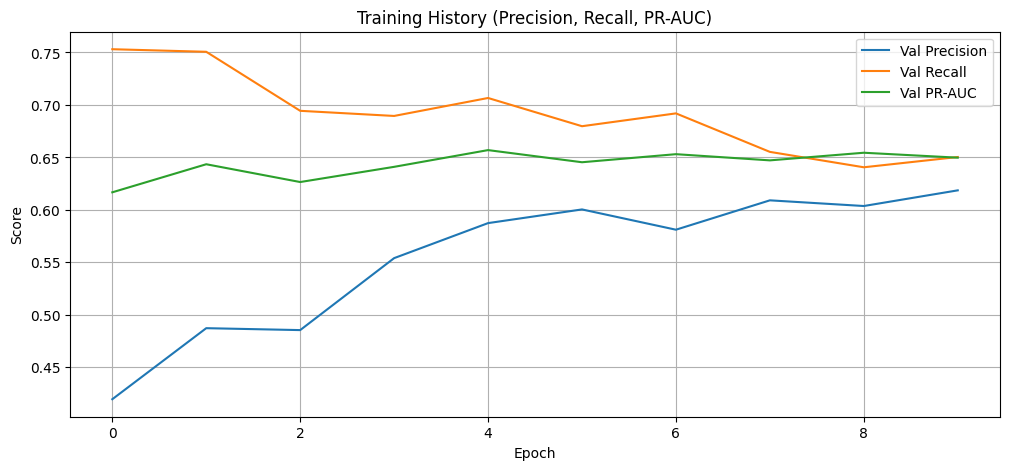

In [23]:
# 10. Plot training history
plt.figure(figsize=(12, 5))

# Precision
# plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')

# Recall
# plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')

# PR-AUC
# plt.plot(history.history['pr_auc'], label='Train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Val PR-AUC')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training History (Precision, Recall, PR-AUC)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
y_probs = model.predict(X_val_scaled)
prec, rec, thresholds = precision_recall_curve(y_val, y_probs)
f2_scores = (5 * prec * rec) / (4 * prec + rec + 1e-9)
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
print("Best threshold for F2:", best_threshold)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F2:", f2_scores[best_idx])

267/267 [==============================] - 0s 635us/step
Best threshold for F2: 0.30472055
Precision: 0.5182119205298014 Recall: 0.7652811735941321 F2: 0.6986607140395448


In [25]:
y_pred = (model.predict(X_test_scaled) > best_threshold).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
pr_auc = average_precision_score(y_test, y_pred)
print("PR AUC:", pr_auc)

267/267 [==============================] - 0s 652us/step
[[7774  307]
 [  85  348]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8081
           1       0.53      0.80      0.64       433

    accuracy                           0.95      8514
   macro avg       0.76      0.88      0.81      8514
weighted avg       0.97      0.95      0.96      8514

PR AUC: 0.4369849492282909


In [26]:
for thr in np.arange(best_threshold, 1.0, 0.01):
    y_pred = (y_probs >= thr).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f"Threshold: {thr:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Threshold: 0.30, Precision: 0.52, Recall: 0.77
Threshold: 0.31, Precision: 0.52, Recall: 0.76
Threshold: 0.32, Precision: 0.53, Recall: 0.76
Threshold: 0.33, Precision: 0.53, Recall: 0.75
Threshold: 0.34, Precision: 0.53, Recall: 0.75
Threshold: 0.35, Precision: 0.54, Recall: 0.75
Threshold: 0.36, Precision: 0.54, Recall: 0.75
Threshold: 0.37, Precision: 0.55, Recall: 0.75
Threshold: 0.38, Precision: 0.55, Recall: 0.74
Threshold: 0.39, Precision: 0.55, Recall: 0.74
Threshold: 0.40, Precision: 0.55, Recall: 0.73
Threshold: 0.41, Precision: 0.55, Recall: 0.73
Threshold: 0.42, Precision: 0.56, Recall: 0.73
Threshold: 0.43, Precision: 0.56, Recall: 0.73
Threshold: 0.44, Precision: 0.57, Recall: 0.73
Threshold: 0.45, Precision: 0.57, Recall: 0.72
Threshold: 0.46, Precision: 0.58, Recall: 0.72
Threshold: 0.47, Precision: 0.58, Recall: 0.71
Threshold: 0.48, Precision: 0.58, Recall: 0.71
Threshold: 0.49, Precision: 0.58, Recall: 0.71
Threshold: 0.50, Precision: 0.59, Recall: 0.70
Threshold: 0.

In [27]:
base_filename = (
    f"prauc_{pr_auc:.3f}_"
    f"thresh_{best_threshold:.3f}_"
    f"prec_{prec[best_idx]:.3f}_"
    f"rec_{rec[best_idx]:.3f}"
)

model_filename = f"model_{base_filename}.keras"
scaler_filename = f"scaler_{base_filename}.pkl"

print(f"Saving model to: {model_filename}")
print(f"Saving scaler to: {scaler_filename}")

Saving model to: model_prauc_0.437_thresh_0.305_prec_0.518_rec_0.765.keras
Saving scaler to: scaler_prauc_0.437_thresh_0.305_prec_0.518_rec_0.765.pkl


In [29]:
model.save(model_filename)

In [30]:
import joblib
joblib.dump(scaler, scaler_filename)

['scaler_prauc_0.437_thresh_0.305_prec_0.518_rec_0.765.pkl']

In [ ]:
# First, install KerasTuner
# !pip install keras-tuner

import keras_tuner as kt

# 1. Create a model-building function
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Tune the number of units in the first Dense layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=1024, step=32)
    model.add(Dense(units=hp_units_1, activation='relu'))
    model.add(BatchNormalization())
    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_1))

    # Add another tunable hidden layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_2, activation='relu'))
    model.add(BatchNormalization())
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))

    # Add another tunable hidden layer
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units_3, activation='relu'))
    model.add(BatchNormalization())
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_3))

    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    
    pr_auc = AUC(curve="PR", name="pr_auc")
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=[pr_auc])
    return model

# 2. Instantiate the tuner
# We'll use Hyperband, an efficient algorithm for finding good hyperparameters
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_pr_auc", direction="max"), # Your key metric
                     max_epochs=20,
                     factor=3,
                     directory='models',
                     project_name='match_tuning')

# Define an early stopping callback to prevent wasting time on bad trials
stop_early = EarlyStopping(monitor='val_pr_auc', mode='max', patience=5)

# 3. Run the search
tuner.search(X_train_scaled, y_train,
             epochs=50,
             validation_data=(X_val_scaled, y_val),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

bprint(f"""
The hyperparameter search is complete.
Optimal units in first layer: {best_hps.get('units_1')}
Optimal dropout in first layer: {best_hps.get('dropout_1')}
Optimal units in second layer: {best_hps.get('units_2')}
Optimal dropout in second layer: {best_hps.get('dropout_2')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# Build the model with the optimal hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), callbacks=[stop_early])

Reloading Tuner from models/match_tuning/tuner0.json

The hyperparameter search is complete.
Optimal units in first layer: 128
Optimal dropout in first layer: 0.2
Optimal units in second layer: 64
Optimal dropout in second layer: 0.2
Optimal learning rate: 0.0001

Epoch 1/50
4043/4043 [==============================] - 10s 2ms/step - loss: 0.3110 - pr_auc: 0.9344 - val_loss: 0.1753 - val_pr_auc: 0.6178
Epoch 2/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1698 - pr_auc: 0.9765 - val_loss: 0.1538 - val_pr_auc: 0.6353
Epoch 3/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1354 - pr_auc: 0.9835 - val_loss: 0.1386 - val_pr_auc: 0.6366
Epoch 4/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1163 - pr_auc: 0.9869 - val_loss: 0.1320 - val_pr_auc: 0.6501
Epoch 5/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1031 - pr_auc: 0.9893 - val_loss: 0.1267 - val_pr_auc: 0.6490
Epoch 6/50
4043/4043 [============

In [ ]:
print(f"""
The hyperparameter search is complete.
Optimal units in first layer: {best_hps.get('units_1')}
Optimal dropout in first layer: {best_hps.get('dropout_1')}
Optimal units in second layer: {best_hps.get('units_2')}
Optimal dropout in second layer: {best_hps.get('dropout_2')}
Optimal learning rate: {best_hps.get('learning_rate')}

""")


The hyperparameter search is complete.
Optimal units in first layer: 128
Optimal dropout in first layer: 0.2
Optimal units in second layer: 64
Optimal dropout in second layer: 0.2
Optimal units in third layer: 32
Optimal dropout in third layer: 0.2
Optimal learning rate: 0.0001




In [ ]:
Trial 30 Complete [00h 02m 04s]
val_pr_auc: 0.6804966926574707

Best val_pr_auc So Far: 0.6804966926574707
Total elapsed time: 00h 29m 50s

The hyperparameter search is complete.
Optimal units in first layer: 128
Optimal dropout in first layer: 0.2
Optimal units in second layer: 64
Optimal dropout in second layer: 0.2
Optimal learning rate: 0.0001

Epoch 1/50
4043/4043 [==============================] - 9s 2ms/step - loss: 0.2522 - pr_auc: 0.9555 - val_loss: 0.1604 - val_pr_auc: 0.6026
Epoch 2/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1399 - pr_auc: 0.9831 - val_loss: 0.1323 - val_pr_auc: 0.6330
Epoch 3/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.1124 - pr_auc: 0.9883 - val_loss: 0.1334 - val_pr_auc: 0.6435
Epoch 4/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.0960 - pr_auc: 0.9906 - val_loss: 0.1202 - val_pr_auc: 0.6559
Epoch 5/50
4043/4043 [==============================] - 9s 2ms/step - loss: 0.0869 - pr_auc: 0.9920 - val_loss: 0.1237 - val_pr_auc: 0.6494
Epoch 6/50
4043/4043 [==============================] - 9s 2ms/step - loss: 0.0801 - pr_auc: 0.9926 - val_loss: 0.1241 - val_pr_auc: 0.6480
Epoch 7/50
4043/4043 [==============================] - 9s 2ms/step - loss: 0.0732 - pr_auc: 0.9939 - val_loss: 0.1307 - val_pr_auc: 0.6428
Epoch 8/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.0677 - pr_auc: 0.9945 - val_loss: 0.1317 - val_pr_auc: 0.6235
Epoch 9/50
4043/4043 [==============================] - 8s 2ms/step - loss: 0.0642 - pr_auc: 0.9949 - val_loss: 0.1256 - val_pr_auc: 0.6428

In [41]:
y_train

74641    0
83928    0
76900    0
57297    0
9632     0
        ..
6265     0
54886    0
76820    0
860      1
15795    0
Name: has_match, Length: 68108, dtype: int64

In [45]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

# 1. Initialize and train the LightGBM model
# Use is_unbalanced=True to let the model handle the class imbalance.
# Train on the original (but scaled) training data, NOT the SMOTE'd data.
lgbm = lgb.LGBMClassifier(objective='binary',
                          n_estimators=1000,
                          learning_rate=0.005,
                          random_state=42,
    scale_pos_weight=scale_pos_weight)

# Train the model
lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         eval_metric="average_precision",
         callbacks=[
             lgb.early_stopping(stopping_rounds=10), # Added stopping_rounds for clarity
             lgb.log_evaluation(period=10)            # This is the line that fixes the error
         ])


# 2. Find the optimal threshold for LightGBM on the validation set (same as you did for the NN)
y_probs_lgbm_val = lgbm.predict_proba(X_val)[:, 1]
prec_lgbm, rec_lgbm, thresholds_lgbm = precision_recall_curve(y_val, y_probs_lgbm_val)
f2_scores_lgbm = (5 * prec_lgbm * rec_lgbm) / (4 * prec_lgbm + rec_lgbm + 1e-9)
best_threshold_lgbm = thresholds_lgbm[np.argmax(f2_scores_lgbm)]

print(f"\nBest Threshold for LightGBM (F2-score): {best_threshold_lgbm:.4f}")

# Evaluate on the test set with the optimized threshold
y_probs_lgbm_test = lgbm.predict_proba(X_test)[:, 1]
y_pred_lgbm_test = (y_probs_lgbm_test >= best_threshold_lgbm).astype(int)

print("\n--- LightGBM Performance on Test Set ---")
print(confusion_matrix(y_test, y_pred_lgbm_test))
print(classification_report(y_test, y_pred_lgbm_test))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3427, number of negative: 64681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.434803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1497459
[LightGBM] [Info] Number of data points in the train set: 68108, number of used features: 6629
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050317 -> initscore=-2.937782
[LightGBM] [Info] Start training from score -2.937782
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.271302	valid_0's binary_logloss: 0.183753
[20]	valid_0's average_precision: 0.282293	valid_0's binary_logloss: 0.182261
Early stopping, best iteration is:
[18]	valid_0's average_precision: 0.281686	valid_0's binary_logloss: 0.182231

Best Thresh

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 1. Initialize and train the Random Forest model
print("--- Training Random Forest ---")
rf = RandomForestClassifier(
    n_estimators=200,          # The number of trees in the forest
    class_weight='balanced',   # Handles class imbalance
    random_state=42,
    n_jobs=-1                  # Use all available CPU cores
)

# Train on the original (un-SMOTEd) data
rf.fit(X_train, y_train)

# 2. Find the optimal threshold on the validation set
y_probs_rf_val = rf.predict_proba(X_val)[:, 1]
prec_rf, rec_rf, thresholds_rf = precision_recall_curve(y_val, y_probs_rf_val)
f2_scores_rf = (5 * prec_rf * rec_rf) / (4 * prec_rf + rec_rf + 1e-9)
best_threshold_rf = thresholds_rf[np.argmax(f2_scores_rf)]

print(f"\nBest Threshold for Random Forest (F2-score): {best_threshold_rf:.4f}")

# 3. Evaluate on the test set with the optimized threshold
y_probs_rf_test = rf.predict_proba(X_test)[:, 1]
y_pred_rf_test = (y_probs_rf_test >= best_threshold_rf).astype(int)

print("\n--- Random Forest Performance on Test Set ---")
print(confusion_matrix(y_test, y_pred_rf_test))
print(classification_report(y_test, y_pred_rf_test))

--- Training Random Forest ---

Best Threshold for Random Forest (F2-score): 0.1000

--- Random Forest Performance on Test Set ---
[[7592  489]
 [ 133  300]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      8081
           1       0.38      0.69      0.49       433

    accuracy                           0.93      8514
   macro avg       0.68      0.82      0.73      8514
weighted avg       0.95      0.93      0.94      8514



In [50]:
from xgboost import XGBClassifier

# 1. Calculate the weight for the positive class
# ratio of negative samples to positive samples
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 2. Initialize and train the XGBoost model
print("\n--- Training XGBoost ---")
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight, # Handles class imbalance
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

# Train the model with early stopping
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False  # Set to True to see training progress
)

# 3. Find the optimal threshold on the validation set
y_probs_xgb_val = xgb.predict_proba(X_val)[:, 1]
prec_xgb, rec_xgb, thresholds_xgb = precision_recall_curve(y_val, y_probs_xgb_val)
f2_scores_xgb = (5 * prec_xgb * rec_xgb) / (4 * prec_xgb + rec_xgb + 1e-9)
best_threshold_xgb = thresholds_xgb[np.argmax(f2_scores_xgb)]

print(f"\nBest Threshold for XGBoost (F2-score): {best_threshold_xgb:.4f}")

# 4. Evaluate on the test set with the optimized threshold
y_probs_xgb_test = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_test = (y_probs_xgb_test >= best_threshold_xgb).astype(int)

print("\n--- XGBoost Performance on Test Set ---")
print(confusion_matrix(y_test, y_pred_xgb_test))
print(classification_report(y_test, y_pred_xgb_test))


--- Training XGBoost ---

Best Threshold for XGBoost (F2-score): 0.0949

--- XGBoost Performance on Test Set ---
[[7546  535]
 [ 102  331]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8081
           1       0.38      0.76      0.51       433

    accuracy                           0.93      8514
   macro avg       0.68      0.85      0.73      8514
weighted avg       0.96      0.93      0.94      8514



In [ ]:
# 1. Get predictions from your trained neural network on the test set
y_probs_test = model.predict(X_test_scaled)
y_pred_test = (y_probs_test > best_threshold).astype(int)

# 2. Create a results DataFrame using the original data
# We use the index of X_test to select the correct rows from the original dataframe
results_df = original_df.loc[X_test.index].copy()
results_df['has_match'] = y_test
results_df['probability'] = y_probs_test
results_df['prediction'] = y_pred_test

# 3. Select relevant columns for a clean view
view_cols = ['need_id', 'need_name', 'offer_name', 'has_match', 'prediction', 'probability']
final_results = results_df[view_cols]

# 4. Group by need_id and display the results
# We'll show a few examples where there was at least one true match in the test set
needs_with_matches_in_test = final_results[final_results['has_match'] == 1]['need_id'].unique()



267/267 [==============================] - 0s 787us/step
\n--- Predictions for Need ID: 4618 (PRÁCTICA OBRERA: Registro de tapas de cámaras en l...) ---
Summary: Found 1 of 1 true matches.
----------------------------------------------------------------------
                                              offer_name  has_match  prediction  probability
                             Práctica Obrera Verano-2022          1           1     0.996601
Dilab-Laboratorio Diseño en Ingeniería y Sistemas 1-2023          0           0     0.000563
                                     Antro-Diseño 1-2023          0           0     0.000015
----------------------------------------------------------------------
\n--- Predictions for Need ID: 8288 (Estudio preinversional proyecto “Espacio Mayor Chi...) ---
Summary: Found 1 of 1 true matches.
----------------------------------------------------------------------
                 offer_name  has_match  prediction  probability
Práctica Profesional 1-2025   

In [47]:
for need_id in needs_with_matches_in_test[:15]: # Displaying first 5 for brevity
    group = final_results[final_results['need_id'] == need_id].sort_values('probability', ascending=False)
    
    # Get the name of the need (they are all the same in the group)
    need_name = group['need_name'].iloc[0]
    
    print(f"\\n--- Predictions for Need ID: {need_id} ({need_name[:50]}...) ---")
    
    # Calculate summary stats for this need
    true_matches = group['has_match'].sum()
    predicted_matches = group['prediction'].sum()
    correctly_predicted = group[(group['has_match'] == 1) & (group['prediction'] == 1)].shape[0]

    print(f"Summary: Found {correctly_predicted} of {true_matches} true matches.")
    print("-" * 70)
    
    # Print the ranked list of potential offers for this need
    print(group[['offer_name', 'has_match', 'prediction', 'probability']].to_string(index=False))
    print("-" * 70)

\n--- Predictions for Need ID: 4618 (PRÁCTICA OBRERA: Registro de tapas de cámaras en l...) ---
Summary: Found 1 of 1 true matches.
----------------------------------------------------------------------
                                              offer_name  has_match  prediction  probability
                             Práctica Obrera Verano-2022          1           1     0.996601
Dilab-Laboratorio Diseño en Ingeniería y Sistemas 1-2023          0           0     0.000563
                                     Antro-Diseño 1-2023          0           0     0.000015
----------------------------------------------------------------------
\n--- Predictions for Need ID: 8288 (Estudio preinversional proyecto “Espacio Mayor Chi...) ---
Summary: Found 1 of 1 true matches.
----------------------------------------------------------------------
                 offer_name  has_match  prediction  probability
Práctica Profesional 1-2025          1           1     0.939067
-----------------------

# 